# Notebook for CRN4

This notebook can be used to generate data on the bursting gene chemical reaction.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib.pyplot as plt

import neuralnetwork
import convert_csv
import generate_data
import simulation
import get_sensitivities
import get_fi
import fsp
import plot

import seaborn
import pandas as pd
from scipy.stats import poisson
import math
from typing import Tuple, Callable

from CRN4_bursting_gene import propensities_bursting_gene as propensities

## Import data

In [2]:
FILE_NAME = 'data'
CRN_NAME = 'bursting_gene'
NUM_PARAMS = 4
NAME = 'Bursting Gene CRN'

Error in data: Inputs have 4 parameters but only the 1st one counts.

In [3]:
# loading data
X_train1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train1.csv')
X_train2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train2.csv')
X_train3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train3.csv')
X_train4 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train4.csv')
X_train5 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train5.csv')
X_train6 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train6.csv')

y_train1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train1.csv')
y_train2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train2.csv')
y_train3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train3.csv')
y_train4 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train4.csv')
y_train5 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train5.csv')
y_train6 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train6.csv')

X_valid1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid1.csv')
X_valid2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid2.csv')
X_valid3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid3.csv')
X_valid4 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid4.csv')
X_valid5 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid5.csv')
X_valid6 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid6.csv')

y_valid1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid1.csv')
y_valid2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid2.csv')
y_valid3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid3.csv')
y_valid4 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid4.csv')
y_valid5 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid5.csv')
y_valid6 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid6.csv')

X_test = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_test.csv')
y_test = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_test.csv')

train_data1 = [X_train1, y_train1]
valid_data1 = [X_valid1, y_valid1]
train_data2 = [X_train2, y_train2]
valid_data2 = [X_valid2, y_valid2]
train_data3 = [X_train3, y_train3]
valid_data3 = [X_valid3, y_valid3]

## Hyperparameters

In [4]:
LR = 0.005
N_ITER = 700
N_HIDDEN = 128
BATCHSIZE = 32
MIXTURE = 'NB'

## Choosing number of components - Elbow method

We use the elbow method to choose the appropriate number of components.

In [9]:
n_comps = np.arange(1, 7)
losses = []
for n in n_comps:
    loss = 0
    for _ in range(3):
        model = neuralnetwork.NeuralNetwork(n_comps=n, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE, print_info=False)
        neuralnetwork.train_NN(model, train_data1, valid_data1, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE, print_results=False, print_info=False)
    loss += neuralnetwork.mean_loss(X_test, y_test, model, loss=neuralnetwork.loss_hellinger).detach().item()
    losses.append(loss/3)
    print(f'Computed loss with {n} components - average loss = {loss/3}.')
plt.plot(n_comps, losses)
plt.xlabel('Number of components')
plt.ylabel('Test loss')
plt.title('Elbow method')
plt.show()

Neural Network created.


Training ...:  20%|██        | 60/300 [00:11<00:46,  5.18it/s]


Neural Network created.


Training ...:  28%|██▊       | 84/300 [00:16<00:43,  5.01it/s]


Neural Network created.


Training ...: 100%|█████████▉| 299/300 [00:57<00:00,  5.22it/s]


Computed loss with 1 components - average loss = 0.27971965074539185.
Neural Network created.


Training ...: 100%|█████████▉| 299/300 [01:13<00:00,  4.06it/s]


Neural Network created.


Training ...:  48%|████▊     | 143/300 [00:33<00:36,  4.24it/s]


Neural Network created.


Training ...: 100%|█████████▉| 299/300 [01:11<00:00,  4.19it/s]


Computed loss with 2 components - average loss = 0.015723223487536114.
Neural Network created.


Training ...: 100%|█████████▉| 299/300 [01:41<00:00,  2.95it/s]


Neural Network created.


Training ...:  35%|███▌      | 105/300 [00:32<01:00,  3.25it/s]


Neural Network created.


Training ...: 100%|█████████▉| 299/300 [01:46<00:00,  2.80it/s]


Computed loss with 3 components - average loss = 0.009038272003332773.
Neural Network created.


Training ...:  57%|█████▋    | 172/300 [00:57<00:42,  2.98it/s]


Neural Network created.


Training ...: 100%|█████████▉| 299/300 [01:39<00:00,  3.00it/s]


Neural Network created.


Training ...: 100%|█████████▉| 299/300 [01:40<00:00,  2.96it/s]


Computed loss with 4 components - average loss = 0.009147006397445997.
Neural Network created.


Training ...: 100%|█████████▉| 299/300 [01:52<00:00,  2.66it/s]


Neural Network created.


Training ...: 100%|█████████▉| 299/300 [01:54<00:00,  2.60it/s]


Neural Network created.


Training ...: 100%|█████████▉| 299/300 [02:12<00:00,  2.26it/s]


Computed loss with 5 components - average loss = 0.008650083715716997.
Neural Network created.


Training ...:   9%|▉         | 28/300 [00:12<02:08,  2.11it/s]

KeyboardInterrupt: 

In [8]:
N_COMPS = 4

## Training models

We train 3 different models to compare their accuracy.

In [9]:
model1 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE)
model2 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE)
model3 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE)

Mixture Density Network created.
Mixture Density Network created.
Mixture Density Network created.


In [31]:
model3 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE)
train_losses3, valid_losses3 = neuralnetwork.train_NN(model3, train_data3, valid_data3, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)

Mixture Density Network created.


Training ...:  18%|█▊        | 123/700 [01:12<05:39,  1.70it/s]

Learning rate: 0.004628663836403689,
Train loss: 0.0027731910813599825,
 Valid loss: 0.0027986494824290276


In [10]:
train_losses1, valid_losses1 = neuralnetwork.train_NN(model1, train_data1, valid_data1, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)
train_losses2, valid_losses2 = neuralnetwork.train_NN(model2, train_data2, valid_data2, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)
train_losses3, valid_losses3 = neuralnetwork.train_NN(model3, train_data3, valid_data3, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)

Training ...:  22%|██▏       | 155/700 [01:23<04:54,  1.85it/s]


Learning rate: 0.004419111850895026,
Train loss: 0.0026107255835086107,
 Valid loss: 0.0025821872986853123


Training ...:  15%|█▌        | 108/700 [00:59<05:27,  1.81it/s]


Learning rate: 0.004712033590374344,
Train loss: 0.002661328297108412,
 Valid loss: 0.002660395111888647


Training ...:  18%|█▊        | 124/700 [01:08<05:18,  1.81it/s]

Learning rate: 0.004622758545555483,
Train loss: 0.003045076970010996,
 Valid loss: 0.003025907324627042


In [11]:
# Compute losses

print("Training dataset")
print(f"KLD : {neuralnetwork.mean_loss(X_train3, y_train3, model3, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_train3, y_train3, model3, loss=neuralnetwork.loss_hellinger)}')

print("\nValidation dataset")
print(f"KLD : {neuralnetwork.mean_loss(X_valid3, y_valid3, model3, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_valid3, y_valid3, model3, loss=neuralnetwork.loss_hellinger)}')

print("\nTest dataset")
print(f"KLD : {neuralnetwork.mean_loss(X_test, y_test, model3, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_test, y_test, model3, loss=neuralnetwork.loss_hellinger)}')


Training dataset
KLD : 0.003045076970010996
Hellinger : 0.028582287952303886

Validation dataset
KLD : 0.003025907324627042
Hellinger : 0.028565336018800735

Test dataset
KLD : 0.003058913629502058
Hellinger : 0.02867320366203785


## Distributions plot


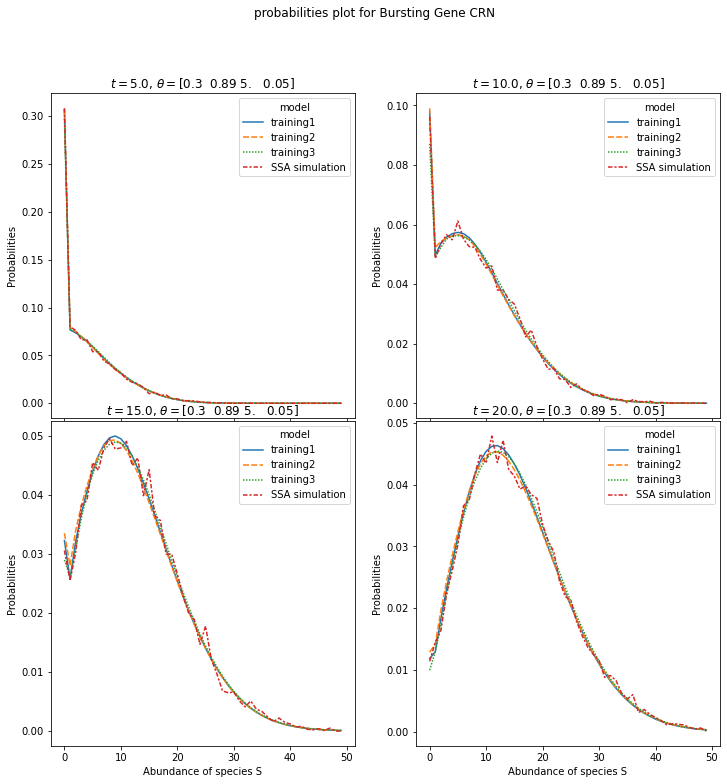

In [32]:
plot.multiple_plots(to_pred=[X_test[20+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound = 4*[50], 
                    n_comps=N_COMPS,
                    plot_test_result=(True, [y_test[20+k,:] for k in range(4)]), 
                    plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None),
                    save=(False, '4distributions_2.png'),
                    crn_name=NAME)

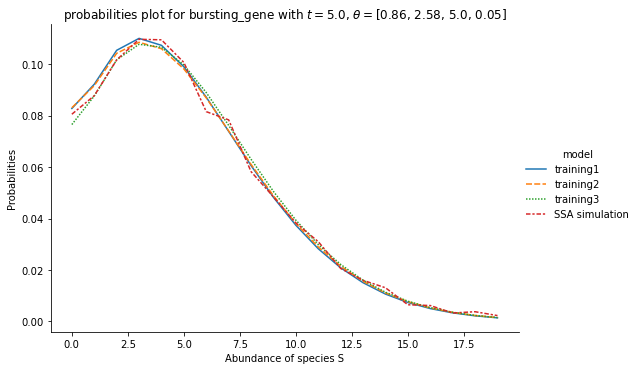

In [33]:
index = 0
plot.plot_model(to_pred=X_test[index,:], 
                models=[model1, model2, model3], 
                up_bound=20,
                n_comps=N_COMPS,
                plot_test_result=(True, y_test[index, :]),
                plot_fsp_result=(True, propensities.stoich_mat, propensities.propensities, 100, None),
                crn_name=CRN_NAME)

We can check the accuracy for higher times than those of the training:

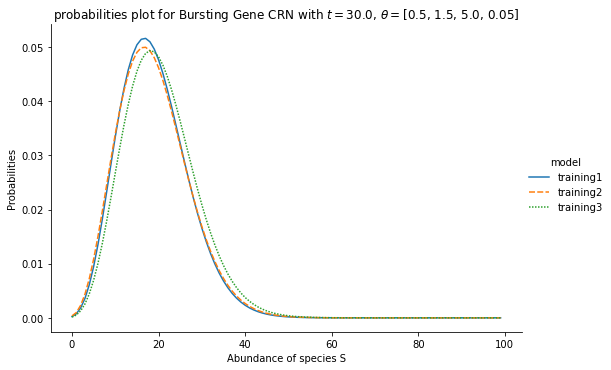

In [34]:
plot.plot_model(to_pred=torch.tensor([30., 0.5, 1.5, 5., 0.05]),
                models=[model1, model2, model3], 
                up_bound = 100,
                n_comps=N_COMPS,
                confidence_interval=False, 
                save=(False, 't50kon4koff13.png'),
                crn_name=NAME)

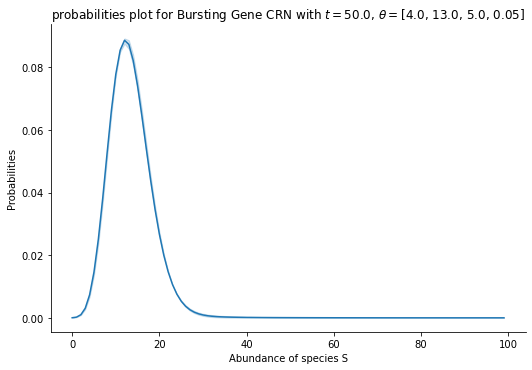

In [35]:
# alpha = 80
plot.plot_model(to_pred=torch.tensor([50., 4, 13, 5., 0.05]), 
                models=[model1, model2, model3], 
                up_bound = 100, 
                n_comps=N_COMPS,
                confidence_interval=True,
                crn_name=NAME)

We can also check the accuracy for parameters outside the bounds of the training.

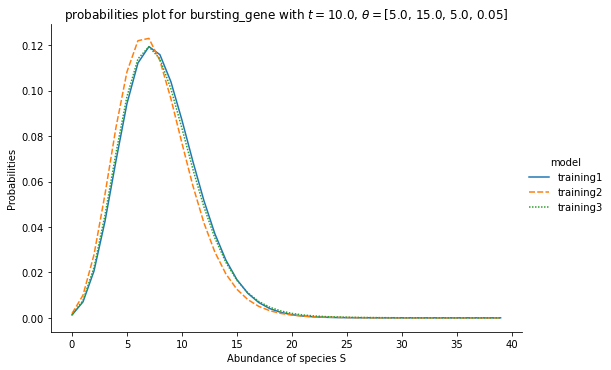

In [36]:
# alpha = 100
plot.plot_model(to_pred=torch.tensor([10., 5., 15, 5., 0.05]), 
                models=[model1, model2, model3], 
                up_bound = 40, 
                n_comps=N_COMPS,
                confidence_interval=False, 
                save=(False, 't10kon5koff15'),
                crn_name=CRN_NAME)

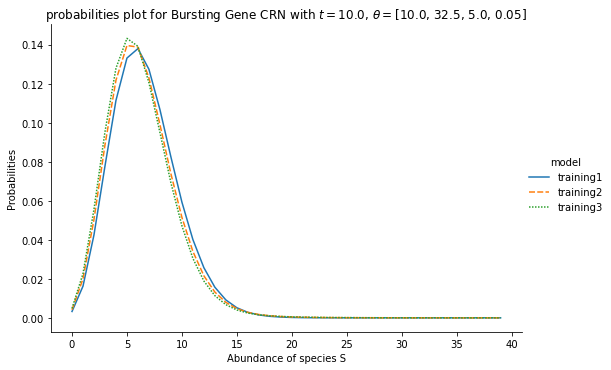

In [37]:
# alpha = 200
plot.plot_model(to_pred=torch.tensor([10., 10., 32.5, 5., 0.05]), 
                models=[model1, model2, model3], 
                up_bound=40, 
                n_comps=N_COMPS,
                confidence_interval=False, 
                save=(False, 't10kon10koff32demi.png'),
                crn_name=NAME)

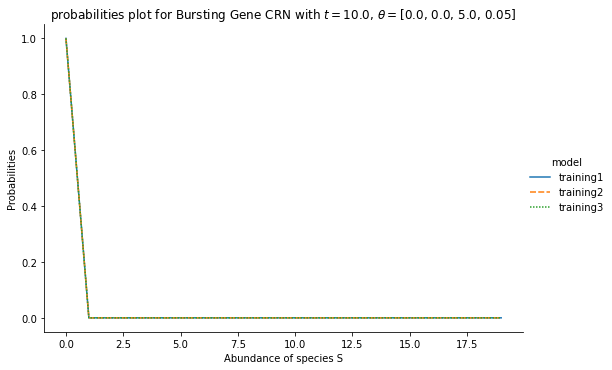

In [38]:
plot.plot_model(to_pred=torch.tensor([10., 0.05*1e-3, 0.15*1e-3, 5., 0.05]), 
                models=[model1, model2, model3], 
                up_bound=20, 
                n_comps=N_COMPS,
                save=(False, 't10kon005e-3koff015e-3.png'),
                crn_name=NAME)

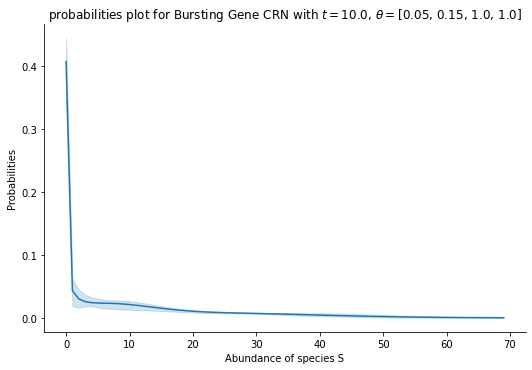

In [39]:
plot.plot_model(to_pred=torch.tensor([10., 0.05, 0.15, 1., 1.]), 
                models=[model1, model2, model3], 
                up_bound=70, 
                n_comps=N_COMPS,
                confidence_interval=True,
                crn_name=NAME)

## Sentivities plot

To compute sensitivities and compare them to the theoretical ones. 

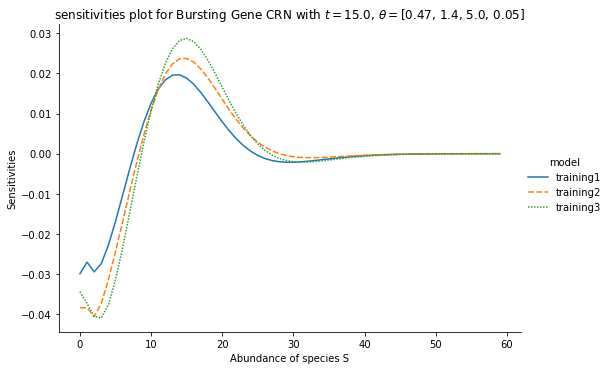

In [40]:
plot.plot_model(to_pred=X_test[10], 
                models=[model1, model2, model3], 
                up_bound=60, 
                n_comps=N_COMPS,
                plot=('sensitivities', 0), 
                index_names = ('Sensitivities', 'Abundance of species S'), 
                save=(False, 'sensitivities_t15kon47koff14.png'),
                crn_name=NAME)

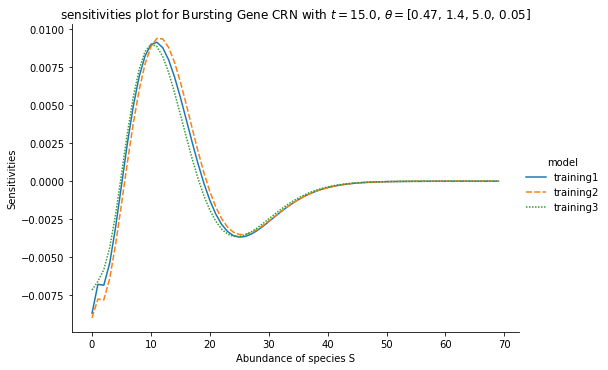

In [41]:
plot.plot_model(to_pred=X_test[10], 
                models=[model1, model2, model3], 
                up_bound=70, 
                n_comps=N_COMPS,
                plot=('sensitivities', 1), 
                confidence_interval=False, 
                index_names=('Sensitivities', 'Abundance of species S'), 
                save=(False, 'sensitivities_koff_t15kon47koff14.png'),
                crn_name=NAME)

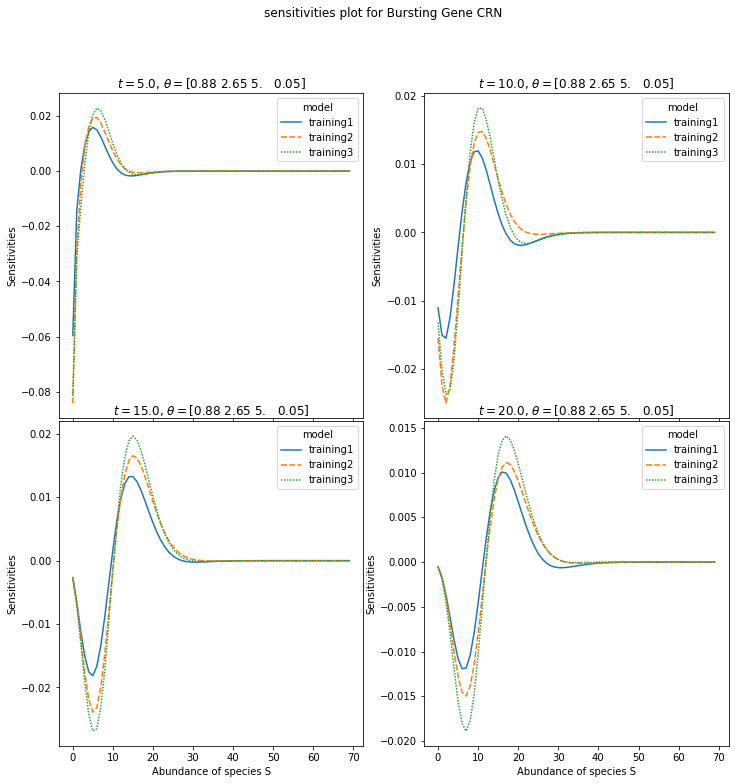

In [42]:
plot.multiple_plots(to_pred=[X_test[992+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound = [70]*5, 
                    n_comps=N_COMPS,
                    plot=('sensitivities', 0), 
                    index_names=('Sensitivities', 'Abundance of species S'),
                    save=(False, 'sensitivities_kon.png'),
                    crn_name=NAME)

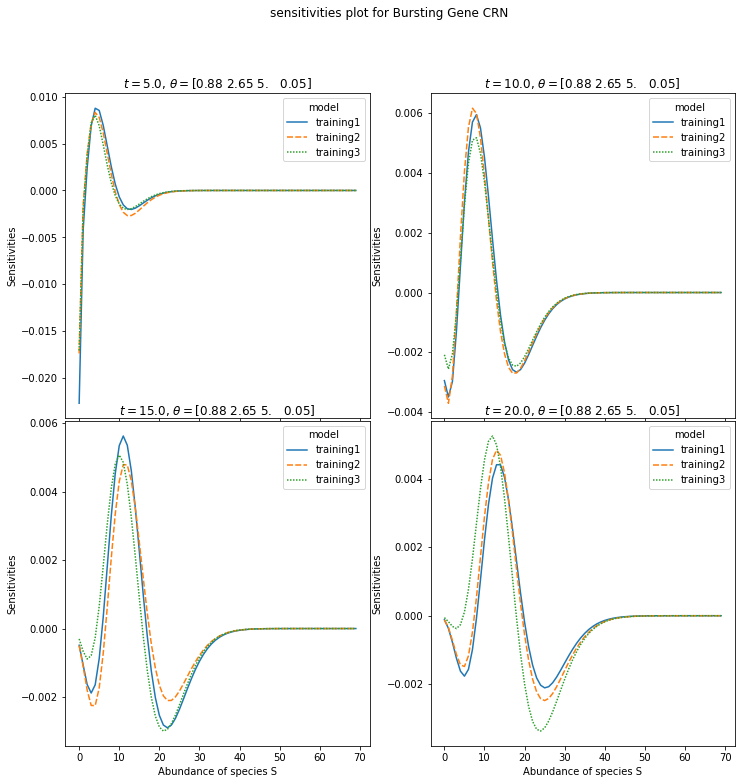

In [43]:
plot.multiple_plots(to_pred=[X_test[992+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound = [70]*5, 
                    n_comps=N_COMPS,
                    plot=('sensitivities', 1), 
                    index_names=('Sensitivities', 'Abundance of species S'), 
                    save=(False, 'sensitivities_koff.png'),
                    crn_name=NAME)

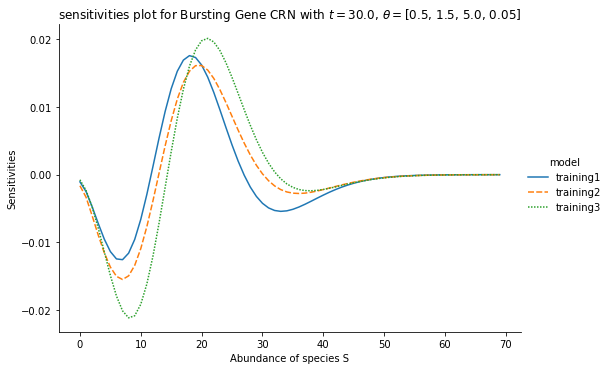

In [44]:
# alpha=10
plot.plot_model(to_pred=torch.tensor([30, 0.5, 1.5, 5, 0.05]), 
                models=[model1, model2, model3], 
                up_bound=70, 
                n_comps=N_COMPS,
                plot=('sensitivities', 0), 
                confidence_interval=False, 
                index_names=('Sensitivities', 'Abundance of species S'), 
                save=(False, 'sensitivities_kon_thigher.png'),
                crn_name=NAME)

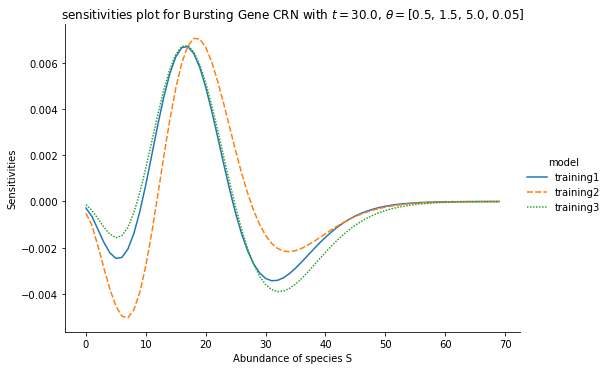

In [45]:
plot.plot_model(to_pred=torch.tensor([30, 0.5, 1.5, 5, 0.05]), 
                models=[model1, model2, model3], 
                up_bound=70, 
                n_comps=N_COMPS,
                plot=('sensitivities', 1), 
                confidence_interval=False, 
                index_names = ('Sensitivities', 'Abundance of species S'),
                save=(False, 'sensitivities_koff_thigher.png'),
                crn_name=NAME)

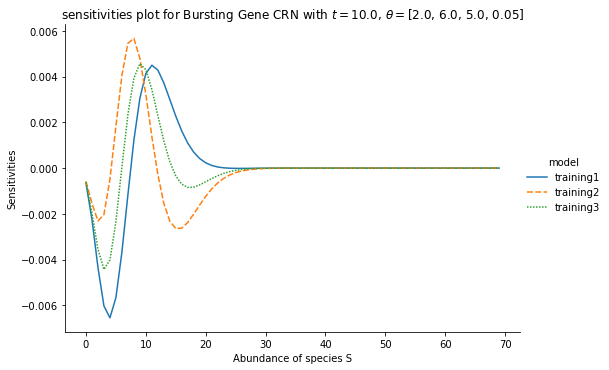

In [46]:
# alpha=40
plot.plot_model(to_pred=torch.tensor([10, 2, 6, 5, 0.05]), 
                models=[model1, model2, model3], 
                up_bound=70, 
                n_comps=N_COMPS,
                plot=('sensitivities', 0), 
                confidence_interval=False, 
                index_names=('Sensitivities', 'Abundance of species S'), 
                save=(False, 'sensitivities_kon_alphahigher.png'),
                crn_name=NAME)

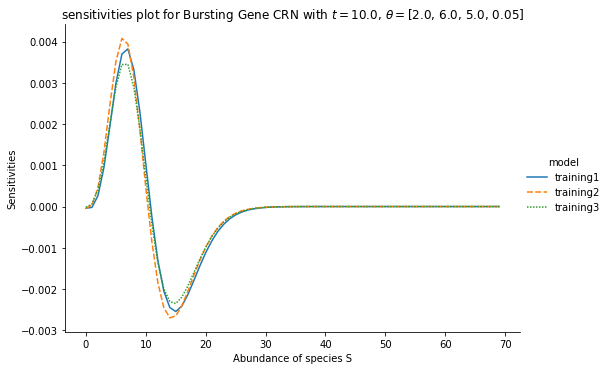

In [47]:
# alpha=40
plot.plot_model(to_pred=torch.tensor([10, 2, 6, 5, 0.05]), 
                models=[model1, model2, model3], 
                up_bound=70,
                n_comps=N_COMPS, 
                plot=('sensitivities', 1), 
                confidence_interval=False, 
                index_names=('Sensitivities', 'Abundance of species S'),
                save=(False, 'sensitivities_koff_alphahigher.png'),
                crn_name=NAME)

## Fisher information

/Users/gabriellelancrey-javal/SynologyDrive/ETH/DL_based_Control_of_CRNs/CRN4_bursting_gene/../plot.py:203: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_pred = torch.concat((torch.tensor([t]), torch.tensor(params)))


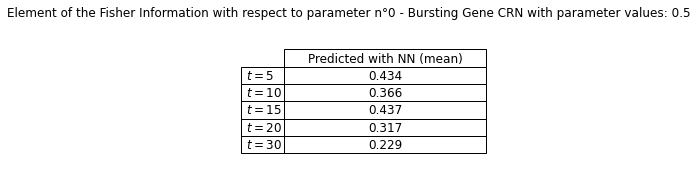

In [48]:
plot.fi_table(time_samples=[5, 10, 15, 20, 30], 
            params=torch.tensor([0.5, 1.5, 5., 0.05]), 
            ind_param=0, 
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_fsp=(False, propensities.stoich_mat, propensities.propensities, 200, None),
            crn_name=NAME)

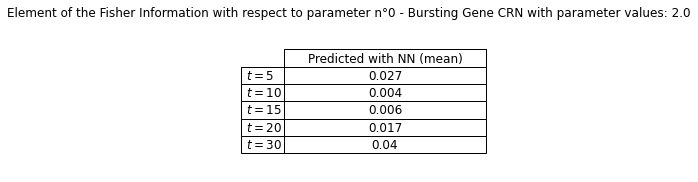

In [49]:
plot.fi_table(time_samples=[5, 10, 15, 20, 30], 
            params=torch.tensor([2, 6, 5., 0.05]), 
            ind_param=0, 
            models=(True, [model1, model2, model3], N_COMPS),
            plot_fsp=(False, propensities.stoich_mat, propensities.propensities, 100, None),
            crn_name=NAME)